# Birds classfication using ResNet18
CSE455 project - Robin Yang, Jack Zhang

## Downloading data

In [3]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c birds-22wi --force

100% 9.20G/9.20G [01:21<00:00, 97.9MB/s]
100% 9.20G/9.20G [01:21<00:00, 121MB/s] 


In [4]:
%%capture
!unzip birds-22wi.zip

In [5]:
# save model to google dive
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/MyDrive/model/model-{}-{}.ckpt"

Mounted at /content/gdrive


## Training

In [8]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
import os
from tqdm import tqdm

cudnn.benchmark = True
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'birds'
ori_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

train_size = int(0.8 * len(ori_datasets['train']))
test_size = len(ori_datasets['train']) - train_size
torch.manual_seed(455)
train_dataset, test_dataset = torch.utils.data.random_split(ori_datasets['train'], [train_size, test_size])

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,
        num_workers=2)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2)

dataloaders = {'train': train_loader, 'test': test_loader}

dataset_sizes = {x: len(dataloaders[x]) * 16 for x in ['train', 'test']}
classes = ori_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# path = 'model/model-{}-{}.ckpt'

def train_model(prev_epochs, model, criterion, optimizer, scheduler, num_epochs):
    for epoch in range(prev_epochs, num_epochs + prev_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1 + prev_epochs))
        print('-' * 10)
        step = 0
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                if (phase == 'train'):
                  step += 1
                  if step % 1000 == 0:
                      # torch.save(model.state_dict(), path.format(epoch + 1, step))
                      checkpoint = {
                          'epoch': epoch + 1,
                          'model': model.state_dict(),
                          'optimizer': optimizer.state_dict(),
                          'lr_sched': scheduler.state_dict()
                          }
                      torch.save(checkpoint, path.format(epoch + 1, step))

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        # torch.save(model.state_dict(), path.format(epoch + 1, step))
        checkpoint = {
            'epoch': epoch + 1,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_sched': scheduler.state_dict()}
        torch.save(checkpoint, path.format(epoch + 1, step))
        print()
    return model

In [ ]:
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(classes)).
# model_ft.fc = nn.Linear(num_ftrs, len(classes))

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(classes))
# model_ft.load_state_dict(torch.load('/content/gdrive/MyDrive/model/model-24-1929.ckpt'))
checkpoint = torch.load('/content/gdrive/MyDrive/model/model-87-1929.ckpt')
prev_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model'])
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.2)
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['lr_sched'])
num_epochs = 3

model = train_model(prev_epoch, model, criterion, optimizer, scheduler, num_epochs)

## Visualize model

In [6]:
import matplotlib.pyplot as plt
import numpy as np

class_id2name = dict()
with open("birds/names.txt") as f:
    for i, line in enumerate(f):
        class_id2name[i] = line;

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.01)

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # print('predicted: {}, Actual: {}'.format(classes[preds[j]], int(labels.cpu().data[j])]))
                ax.set_title('predicted: {}, Actual: {}'.format(class_id2name[int(classes[preds[j]])], class_id2name[int(classes[labels.cpu().data[j]])]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

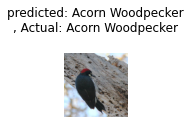

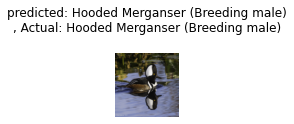

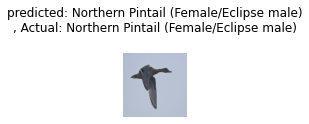

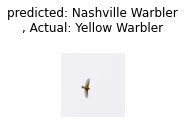

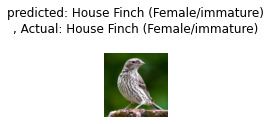

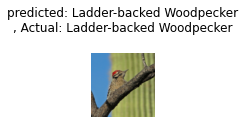

In [14]:
from torchvision import datasets, models, transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'birds'
ori_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

train_size = int(0.8 * len(ori_datasets['train']))
test_size = len(ori_datasets['train']) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ori_datasets['train'], [train_size, test_size])

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,
        num_workers=2)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2)

dataloaders = {'train': train_loader, 'test': test_loader}

dataset_sizes = {x: len(dataloaders[x]) * 16 for x in ['train', 'test']}
classes = ori_datasets['train'].classes

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(classes))
# model_ft.load_state_dict(torch.load('/content/gdrive/MyDrive/model/model-24-1929.ckpt'))
checkpoint = torch.load('/content/gdrive/MyDrive/model/model-88-1929.ckpt')
prev_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model'])
model = model.to(device)

visualize_model(model)

In [ ]:
def get_loss_acc(prev_epochs, model, criterion, num_epochs):
    for epoch in range(prev_epochs, num_epochs + prev_epochs):
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, len(classes))
        checkpoint = torch.load('/content/gdrive/MyDrive/model/model-{}-1929.ckpt'.format(epoch))
        if 'model' in checkpoint:
            model.load_state_dict(checkpoint['model'])
        else:
            model.load_state_dict(checkpoint)
        model = model.to(device)

        for phase in ['train', 'test']:
            model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(False):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            model_only = 1
            if 'model' in checkpoint:
                model_only = 0
            print('{}, {}, {}, {:.4f}, {:.4f}'.format(
                epoch, phase, model_only, epoch_loss, epoch_acc))
criterion = nn.CrossEntropyLoss()
get_loss_acc(1, model, criterion, 88)